In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')
print(device)

cpu


In [ ]:
# standardization code
standardizator = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=(0.5,), std=(0.5,))])

# MNIST dataset
train_data = dsets.MNIST(root='data/', train=True, transform=standardizator, download=True)
test_data  = dsets.MNIST(root='data/', train=False, transform=standardizator, download=True)


batch_size = 200
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
test_data_loader  = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



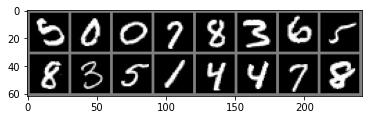

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

def imshow(img):
    img = (img+1)/2    
    img = img.squeeze()
    np_img = img.numpy()
    plt.imshow(np_img, cmap='gray')
    plt.show()

def imshow_grid(img):
    img = utils.make_grid(img.cpu().detach())
    img = (img+1)/2
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

example_mini_batch_img, example_mini_batch_label  = next(iter(train_data_loader))
imshow_grid(example_mini_batch_img[0:16,:,:])

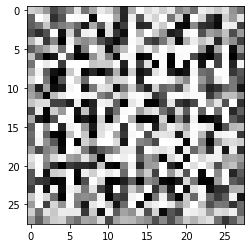

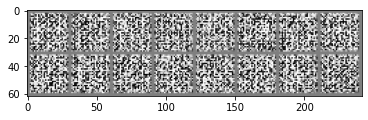

In [ ]:
d_noise  = 100
d_hidden = 256
d_output = example_mini_batch_img.size(1)

def sample_z(batch_size = 1, d_noise=100):
    return torch.randn(batch_size, d_noise, 1, 1, device=device)

G = nn.Sequential( 
    nn.ConvTranspose2d(in_channels=d_noise, out_channels=64*4, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(64*4),
    nn.ReLU(True),

    nn.ConvTranspose2d(in_channels=64*4, out_channels=64*2, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64*2),
    nn.ReLU(True),

    nn.ConvTranspose2d(in_channels=64*2, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(in_channels=64, out_channels=d_output, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    ).to(device)

# 노이즈 생성하기
z = sample_z()
# 가짜 이미지 생성하기
img_fake = G(z)
# 이미지 출력하기
imshow(img_fake.squeeze().cpu().detach())

# Batch SIze만큼 노이즈 생성하여 그리드로 출력하기
z = sample_z(batch_size)
img_fake = G(z)
imshow_grid(img_fake[0:16,:,:])

In [ ]:
D = nn.Sequential(
    nn.Conv2d(in_channels=d_output, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(in_channels=64, out_channels=64*2, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64*2),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(in_channels=64*2, out_channels=64*4, kernel_size=3, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64*4),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(in_channels=64*4, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Sigmoid()
    ).to(device)

print(G(z).shape)
print(D(G(z)).shape)
print(D(G(z)[0:5]).transpose(0,1))

torch.Size([200, 1, 28, 28])
torch.Size([200, 1, 1, 1])
tensor([[[[0.4827]],

         [[0.5129]],

         [[0.6201]],

         [[0.5475]],

         [[0.3879]]]], device='cuda:0', grad_fn=<TransposeBackward0>)


In [ ]:
criterion = nn.BCELoss()

def run_epoch(generator, discriminator, _optimizer_g, _optimizer_d):

    generator.train()
    discriminator.train()

    for img_batch, label_batch in train_data_loader:

        img_batch, label_batch = img_batch.to(device), label_batch.to(device)
        
        # ================================================  #
        # maximize V(discriminator,generator) = optimize discriminator (setting k to be 1)  #
        # ================================================  #

        # init optimizer
        _optimizer_d.zero_grad()

        p_real = discriminator(img_batch).view(-1)
        p_fake = discriminator(generator(sample_z(batch_size, d_noise))).view(-1)

        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #
        # loss_real = -1 * torch.log(p_real)   # -1 for gradient ascending
        # loss_fake = -1 * torch.log(1.-p_fake) # -1 for gradient ascending
        # loss_d    = (loss_real + loss_fake).mean()

        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        loss_d = criterion(p_real, torch.ones_like(p_real).to(device)) + criterion(p_fake, torch.zeros_like(p_real).to(device)) 

        # Update parameters
        loss_d.backward()
        _optimizer_d.step()

        # ================================================  #
        #        minimize V(discriminator,generator)        #
        # ================================================  #

        # init optimizer
        _optimizer_g.zero_grad()

        p_fake = discriminator(generator(sample_z(batch_size, d_noise))).view(-1)

        # ================================================  #
        #    Loss computation (soley based on the paper)    #
        # ================================================  #

        #loss_g = -1 * torch.log(p_fake).mean()

        # ================================================  #
        #     Loss computation (based on Cross Entropy)     #
        # ================================================  #
        loss_g = criterion(p_fake, torch.ones_like(p_fake).to(device)) 

        loss_g.backward()

        # Update parameters
        _optimizer_g.step()

def evaluate_model(generator, discriminator):

    p_real, p_fake = 0.,0.

    generator.eval()
    discriminator.eval()

    for img_batch, label_batch in test_data_loader:

        img_batch, label_batch = img_batch.to(device), label_batch.to(device)

        with torch.autograd.no_grad():
            p_real += (torch.sum(discriminator(img_batch)).item())/10000.
            p_fake += (torch.sum(discriminator(generator(sample_z(batch_size, d_noise)))).item())/10000.


    return p_real, p_fake

(epoch 1/200) p_real: 0.658330, p_g: 0.000981
(epoch 2/200) p_real: 0.183091, p_g: 0.000170
(epoch 3/200) p_real: 0.019895, p_g: 0.000097
(epoch 4/200) p_real: 0.999210, p_g: 0.233841
(epoch 5/200) p_real: 0.294413, p_g: 0.000121
(epoch 6/200) p_real: 0.304419, p_g: 0.000021
(epoch 7/200) p_real: 0.112422, p_g: 0.000001
(epoch 8/200) p_real: 0.069783, p_g: 0.000003
(epoch 9/200) p_real: 0.070475, p_g: 0.000002
(epoch 10/200) p_real: 0.017181, p_g: 0.000003


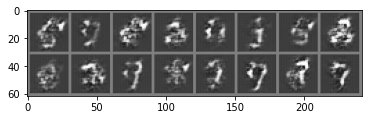

(epoch 11/200) p_real: 0.227487, p_g: 0.000496
(epoch 12/200) p_real: 0.045100, p_g: 0.001379
(epoch 13/200) p_real: 0.006207, p_g: 0.000290
(epoch 14/200) p_real: 0.066578, p_g: 0.016723
(epoch 15/200) p_real: 0.055832, p_g: 0.029646
(epoch 16/200) p_real: 0.474280, p_g: 0.043521
(epoch 17/200) p_real: 0.747139, p_g: 0.100361
(epoch 18/200) p_real: 0.746580, p_g: 0.156487
(epoch 19/200) p_real: 0.565973, p_g: 0.038670
(epoch 20/200) p_real: 0.728616, p_g: 0.134555


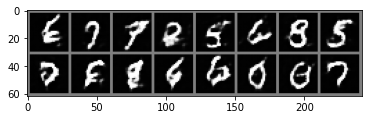

(epoch 21/200) p_real: 0.695484, p_g: 0.109499
(epoch 22/200) p_real: 0.799689, p_g: 0.240132
(epoch 23/200) p_real: 0.637564, p_g: 0.174025
(epoch 24/200) p_real: 0.563798, p_g: 0.123664
(epoch 25/200) p_real: 0.640603, p_g: 0.277626
(epoch 26/200) p_real: 0.566707, p_g: 0.191760
(epoch 27/200) p_real: 0.804263, p_g: 0.438856
(epoch 28/200) p_real: 0.635746, p_g: 0.271453
(epoch 29/200) p_real: 0.700449, p_g: 0.315178
(epoch 30/200) p_real: 0.204934, p_g: 0.040608


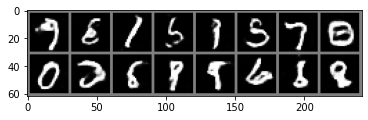

(epoch 31/200) p_real: 0.785176, p_g: 0.430361
(epoch 32/200) p_real: 0.780564, p_g: 0.388435
(epoch 33/200) p_real: 0.637531, p_g: 0.264009
(epoch 34/200) p_real: 0.806656, p_g: 0.512077
(epoch 35/200) p_real: 0.632848, p_g: 0.271480
(epoch 36/200) p_real: 0.916633, p_g: 0.739913
(epoch 37/200) p_real: 0.224038, p_g: 0.061163
(epoch 38/200) p_real: 0.720554, p_g: 0.265484
(epoch 39/200) p_real: 0.465358, p_g: 0.234413
(epoch 40/200) p_real: 0.292405, p_g: 0.105726


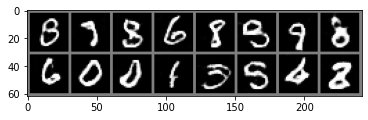

(epoch 41/200) p_real: 0.764300, p_g: 0.472890
(epoch 42/200) p_real: 0.761235, p_g: 0.321980
(epoch 43/200) p_real: 0.509510, p_g: 0.216684
(epoch 44/200) p_real: 0.294556, p_g: 0.096363
(epoch 45/200) p_real: 0.524120, p_g: 0.236886
(epoch 46/200) p_real: 0.267238, p_g: 0.082050
(epoch 47/200) p_real: 0.513308, p_g: 0.278818
(epoch 48/200) p_real: 0.520235, p_g: 0.446047
(epoch 49/200) p_real: 0.467428, p_g: 0.199196
(epoch 50/200) p_real: 0.366153, p_g: 0.153261


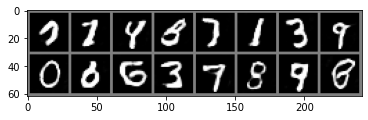

(epoch 51/200) p_real: 0.658205, p_g: 0.389578
(epoch 52/200) p_real: 0.950082, p_g: 0.776318
(epoch 53/200) p_real: 0.484966, p_g: 0.167133
(epoch 54/200) p_real: 0.700901, p_g: 0.279030
(epoch 55/200) p_real: 0.347646, p_g: 0.118451
(epoch 56/200) p_real: 0.490879, p_g: 0.196964
(epoch 57/200) p_real: 0.692770, p_g: 0.474321
(epoch 58/200) p_real: 0.447200, p_g: 0.204878
(epoch 59/200) p_real: 0.558773, p_g: 0.295839
(epoch 60/200) p_real: 0.629546, p_g: 0.322528


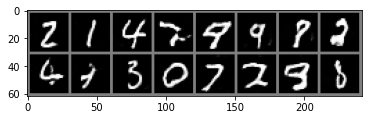

(epoch 61/200) p_real: 0.707292, p_g: 0.394878
(epoch 62/200) p_real: 0.664585, p_g: 0.446723
(epoch 63/200) p_real: 0.728693, p_g: 0.439733
(epoch 64/200) p_real: 0.576849, p_g: 0.311379
(epoch 65/200) p_real: 0.538945, p_g: 0.330227
(epoch 66/200) p_real: 0.572667, p_g: 0.286921
(epoch 67/200) p_real: 0.686086, p_g: 0.337720
(epoch 68/200) p_real: 0.588484, p_g: 0.299708
(epoch 69/200) p_real: 0.585456, p_g: 0.262695
(epoch 70/200) p_real: 0.609759, p_g: 0.318850


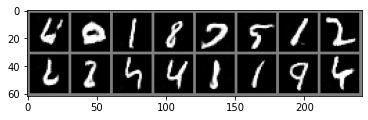

(epoch 71/200) p_real: 0.601975, p_g: 0.263165
(epoch 72/200) p_real: 0.599667, p_g: 0.388019
(epoch 73/200) p_real: 0.527661, p_g: 0.245308
(epoch 74/200) p_real: 0.592103, p_g: 0.242077
(epoch 75/200) p_real: 0.568813, p_g: 0.362664
(epoch 76/200) p_real: 0.664177, p_g: 0.414110
(epoch 77/200) p_real: 0.533840, p_g: 0.249983
(epoch 78/200) p_real: 0.495748, p_g: 0.208253
(epoch 79/200) p_real: 0.599103, p_g: 0.360203
(epoch 80/200) p_real: 0.661104, p_g: 0.553515


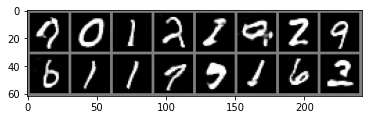

(epoch 81/200) p_real: 0.746220, p_g: 0.405685
(epoch 82/200) p_real: 0.481852, p_g: 0.242101
(epoch 83/200) p_real: 0.602010, p_g: 0.401053
(epoch 84/200) p_real: 0.510271, p_g: 0.302894
(epoch 85/200) p_real: 0.544960, p_g: 0.289073
(epoch 86/200) p_real: 0.746570, p_g: 0.553887
(epoch 87/200) p_real: 0.745131, p_g: 0.448435
(epoch 88/200) p_real: 0.565302, p_g: 0.302380
(epoch 89/200) p_real: 0.441646, p_g: 0.216463
(epoch 90/200) p_real: 0.522709, p_g: 0.279638


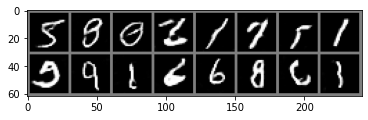

(epoch 91/200) p_real: 0.589466, p_g: 0.393174
(epoch 92/200) p_real: 0.635366, p_g: 0.377799
(epoch 93/200) p_real: 0.561407, p_g: 0.312690
(epoch 94/200) p_real: 0.545264, p_g: 0.248516
(epoch 95/200) p_real: 0.512571, p_g: 0.252623
(epoch 96/200) p_real: 0.500791, p_g: 0.217189
(epoch 97/200) p_real: 0.552603, p_g: 0.364043
(epoch 98/200) p_real: 0.598602, p_g: 0.348710
(epoch 99/200) p_real: 0.564795, p_g: 0.407591
(epoch 100/200) p_real: 0.631263, p_g: 0.415207


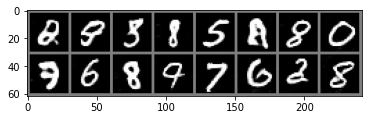

(epoch 101/200) p_real: 0.651816, p_g: 0.338858
(epoch 102/200) p_real: 0.437130, p_g: 0.202146
(epoch 103/200) p_real: 0.688921, p_g: 0.431088
(epoch 104/200) p_real: 0.511128, p_g: 0.302352
(epoch 105/200) p_real: 0.414767, p_g: 0.297108
(epoch 106/200) p_real: 0.609538, p_g: 0.380821
(epoch 107/200) p_real: 0.677477, p_g: 0.409589
(epoch 108/200) p_real: 0.526125, p_g: 0.255336
(epoch 109/200) p_real: 0.612157, p_g: 0.365534
(epoch 110/200) p_real: 0.604279, p_g: 0.388249


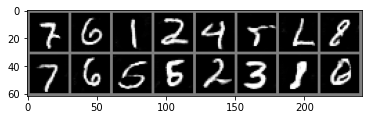

(epoch 111/200) p_real: 0.648403, p_g: 0.338655
(epoch 112/200) p_real: 0.745080, p_g: 0.562050
(epoch 113/200) p_real: 0.697007, p_g: 0.372504
(epoch 114/200) p_real: 0.684388, p_g: 0.459380
(epoch 115/200) p_real: 0.438610, p_g: 0.290043
(epoch 116/200) p_real: 0.610322, p_g: 0.399869
(epoch 117/200) p_real: 0.687885, p_g: 0.371844
(epoch 118/200) p_real: 0.342444, p_g: 0.188089
(epoch 119/200) p_real: 0.507454, p_g: 0.254498
(epoch 120/200) p_real: 0.429570, p_g: 0.232588


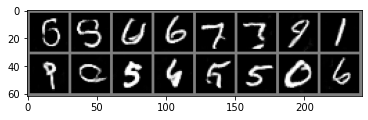

(epoch 121/200) p_real: 0.591472, p_g: 0.392298
(epoch 122/200) p_real: 0.604789, p_g: 0.415399
(epoch 123/200) p_real: 0.463896, p_g: 0.290628
(epoch 124/200) p_real: 0.625087, p_g: 0.464521
(epoch 125/200) p_real: 0.618993, p_g: 0.396622
(epoch 126/200) p_real: 0.539782, p_g: 0.345420
(epoch 127/200) p_real: 0.614857, p_g: 0.375122
(epoch 128/200) p_real: 0.550122, p_g: 0.308697
(epoch 129/200) p_real: 0.539405, p_g: 0.377951
(epoch 130/200) p_real: 0.359469, p_g: 0.157978


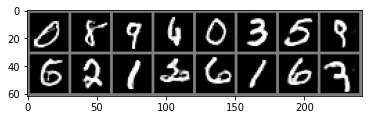

(epoch 131/200) p_real: 0.358517, p_g: 0.181617
(epoch 132/200) p_real: 0.450838, p_g: 0.215588
(epoch 133/200) p_real: 0.468046, p_g: 0.294598
(epoch 134/200) p_real: 0.564114, p_g: 0.367488
(epoch 135/200) p_real: 0.545598, p_g: 0.379293
(epoch 136/200) p_real: 0.619721, p_g: 0.379642
(epoch 137/200) p_real: 0.455276, p_g: 0.230614
(epoch 138/200) p_real: 0.745024, p_g: 0.466727
(epoch 139/200) p_real: 0.516770, p_g: 0.322264
(epoch 140/200) p_real: 0.622452, p_g: 0.363953


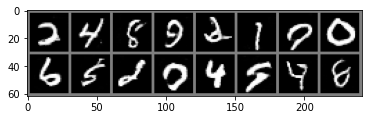

(epoch 141/200) p_real: 0.561283, p_g: 0.331490
(epoch 142/200) p_real: 0.615700, p_g: 0.429527
(epoch 143/200) p_real: 0.468963, p_g: 0.259025
(epoch 144/200) p_real: 0.589203, p_g: 0.418236
(epoch 145/200) p_real: 0.449788, p_g: 0.249003
(epoch 146/200) p_real: 0.493843, p_g: 0.360487
(epoch 147/200) p_real: 0.600588, p_g: 0.411460
(epoch 148/200) p_real: 0.484286, p_g: 0.250584
(epoch 149/200) p_real: 0.485348, p_g: 0.315637
(epoch 150/200) p_real: 0.428752, p_g: 0.244883


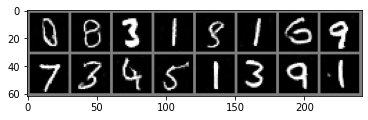

(epoch 151/200) p_real: 0.205192, p_g: 0.089178
(epoch 152/200) p_real: 0.609263, p_g: 0.380861


In [ ]:
def init_params(model):
    for p in model.parameters():
        if(p.dim() > 1):
            nn.init.xavier_normal_(p)
        else:
            nn.init.uniform_(p, 0.1, 0.2)

init_params(G)
init_params(D)

optimizer_g = optim.Adam(G.parameters(), lr = 0.0002)
optimizer_d = optim.Adam(D.parameters(), lr = 0.0002)

p_real_trace = []
p_fake_trace = []

for epoch in range(200):

    generator.train()
    discriminator.train()

    run_epoch(G, D, optimizer_g, optimizer_d)
    p_real, p_fake = evaluate_model(G,D)

    p_real_trace.append(p_real)
    p_fake_trace.append(p_fake)

    print('(epoch %i/200) p_real: %f, p_g: %f' % (epoch+1, p_real, p_fake))

    if((epoch+1)% 10 == 0):
        imshow_grid(G(sample_z(16)))


In [ ]:
import matplotlib.pyplot as plt
plt.plot(p_fake_trace, label='D(x_generated)')
plt.plot(p_real_trace, label='D(x_real)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()